### Table of Contents
- [Introduction](#Introduction)
- [Part 1 - Imports](#Imports)
- [Part 2 - Helper Functions](#Helper-Functions)
- [Part 3 - Load Data](#Load-data)
- [Part 4 - Data Preprocessing](#Data-Preprocessing)
- [Part 5 - Exploartory Data Analysis](#EDA)
- [Part 6 - Topic Modeling ](#Topic-Modeling)
- [Part 7 - Conclusion](#Conclusion)

# Introduction

In this notebook we're going to get the topics for the articles in our dataset  

# Imports 

In [424]:
import pandas as pd
import numpy as np
import pickle


from sklearn.preprocessing import PolynomialFeatures
from datetime import date
import re, nltk, gensim,spacy,string
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tag import pos_tag
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect



from corextopic import corextopic as ct
from corextopic import vis_topic as vt



import seaborn as sns



from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

#  Helper Functions

In [425]:
def preprocess(abstract):
    abstract = abstract.lower() #lowercase text
    abstract=abstract.strip()  #get rid of leading/trailing whitespace 
    abstract=re.compile('<.*?>').sub('', abstract) #Remove HTML tags/markups
    abstract = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', abstract)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    abstract = re.sub('\s+', ' ', abstract)  #Remove extra space and tabs
    abstract = re.sub(r'\[[0-9]*\]',' ',abstract) #[0-9] matches any digit (0 to 10000...)
    abstract=re.sub(r'[^\w\s]', '', str(abstract).lower().strip())
    abstract = re.sub(r'\d',' ',abstract) #matches any digit from 0 to 100000..., \D matches non-digits
    abstract = re.sub(r'\s+',' ',abstract) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return abstract


stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['research','article','review','paper','chapter','literature'
                ,'social','survey','use','data','dy','also','objective','two','used'
               ,'one','analysis','using',]

def stopword(string):

    stopwords.extend(newStopWords)
    string=pos(string)
    a= [i for i in string if i not in stopwords]
    print (a)
    return ' '.join(a)

 

lemmer = WordNetLemmatizer()
def lemme(string):
    a=[lemmer.lemmatize(i) for i in word_tokenize(string) ]
    return " ".join(a)






def pos(string):
    tokens = pos_tag(word_tokenize(string))
    #return  [ x for (x,y) in tokens if y in (['NN','NNP'])]
    return  [ x for (x,y) in tokens if y not in ('jj')]



tfidf = TfidfVectorizer()
def TfidfVect(abstract):   
    # new TF-IDF Vectorizer
    X_tfidf = tfidf.fit_transform(abstract).toarray()
    df_tf=pd.DataFrame(X_tfidf,index= df['abstract'],columns=tfidf.get_feature_names())
    return df_tf

cv = CountVectorizer()
def CountVect(abstract):   
    # Count Vectorizer
    X_cv = cv.fit_transform(abstract).toarray()
    df_cv=pd.DataFrame(X_cv,index= df['abstract'],columns=cv.get_feature_names())
    return df_cv



def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
        



#def get_length()

In [426]:
def get_top_n_grams(corpus,r ,n=None):
    vec = CountVectorizer(ngram_range=r, stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Load Data

In [4]:
df=pd.read_csv("data/data2.csv")

In [5]:
df_or=df.copy(deep=True)

In [6]:
df.head()

,title,authers,abstract,type,date_pub,journal,date_added,figuers,full_text,citation,interest,reads
0,Media and time,"['Emily Keightley', 'Sabina Mihelj', 'Aswin Pu...",NaN,Article,2021.0,Media Culture & Society,13h ago,0,\nRequest full-text,0,NaN,17
1,Myths about Myths? A Commentary on Thomas (202...,"['Ellen Daly', 'Olivia Smith', 'Hannah Bows[.....",This commentary responds to claims that resear...,Article,2021.0,Journal of Gender-Based Violence,6d ago,1,\nDownload,0,1.0,32
2,Creative Memory,"['Jasmine Hornabrook', 'Clelia Clini', 'Emily ...",NaN,Chapter,2021.0,NaN,Nov 18,0,\nRequest full-text,0,0.0,7
3,The United Kingdom Independence Party (UKIP) a...,"['David Deacon', 'Dominic Wring']",NaN,Chapter,2015.0,NaN,Oct 30,0,\nRequest full-text,0,NaN,2
4,A direct observation of pain scale use in five...,"['Laura Jenkins', 'Ruth H Parry', 'Christina F...",Objective Assessing pain intensity is an impor...,Article,2021.0,Patient Education and Counseling,Oct 28,0,\nRequest full-text,0,0.0,9


In [7]:
df.shape

(1899, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1899 entries, 0 to 1898
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       1899 non-null   object 
 1   authers     1899 non-null   object 
 2   abstract    1283 non-null   object 
 3   type        1899 non-null   object 
 4   date_pub    1083 non-null   float64
 5   journal     1018 non-null   object 
 6   date_added  1043 non-null   object 
 7   figuers     1899 non-null   int64  
 8   full_text   1899 non-null   object 
 9   citation    1899 non-null   int64  
 10  interest    1620 non-null   float64
 11  reads       1899 non-null   int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 178.2+ KB


In [9]:
df['detect'] = df['title'].apply(detect)


In [10]:
df.head()

,title,authers,abstract,type,date_pub,journal,date_added,figuers,full_text,citation,interest,reads,detect
0,Media and time,"['Emily Keightley', 'Sabina Mihelj', 'Aswin Pu...",NaN,Article,2021.0,Media Culture & Society,13h ago,0,\nRequest full-text,0,NaN,17,en
1,Myths about Myths? A Commentary on Thomas (202...,"['Ellen Daly', 'Olivia Smith', 'Hannah Bows[.....",This commentary responds to claims that resear...,Article,2021.0,Journal of Gender-Based Violence,6d ago,1,\nDownload,0,1.0,32,en
2,Creative Memory,"['Jasmine Hornabrook', 'Clelia Clini', 'Emily ...",NaN,Chapter,2021.0,NaN,Nov 18,0,\nRequest full-text,0,0.0,7,en
3,The United Kingdom Independence Party (UKIP) a...,"['David Deacon', 'Dominic Wring']",NaN,Chapter,2015.0,NaN,Oct 30,0,\nRequest full-text,0,NaN,2,en
4,A direct observation of pain scale use in five...,"['Laura Jenkins', 'Ruth H Parry', 'Christina F...",Objective Assessing pain intensity is an impor...,Article,2021.0,Patient Education and Counseling,Oct 28,0,\nRequest full-text,0,0.0,9,en


In [11]:
df= df[df['detect']=='en']

In [12]:
df=df.drop(columns='detect',axis=1)

In [13]:
df.shape

(1723, 12)

In [14]:
df=df.dropna(subset = ['abstract'])

In [15]:
df.shape

(1185, 12)

In [16]:
a = 1
for i in range(a,a+1):
    print(df.abstract[i])
    print()

This commentary responds to claims that research by Cheryl Thomas 'shows' no problem with rape myths in English and Welsh juries. We critique the claim on the basis of ambiguous survey design, a false distinction between 'real' jurors and other research participants, the conflation of attitudes in relation to abstract versus applied rape myths, and misleading interpretation of the data. Ultimately, we call for a balanced appraisal of individual studies by contextualising them against the wider literature.



In [17]:
df['or_abt'] = df['abstract']

# Data Preprocessing

In [ ]:
df['abstract']= df["abstract"].apply(preprocess)
df['abstract']= df["abstract"].apply(stopword)
df['abstract']= df["abstract"].apply(lemme)

In [28]:
df['abstract'].head()

1     commentary responds claim cheryl thomas show p...
4     assessing pain intensity important palliative ...
5     describes art curating sexually exploited youn...
7     objective many study document high prevalence ...
10    background communication skill training profes...
Name: abstract, dtype: object

## EDA

### most frequent words

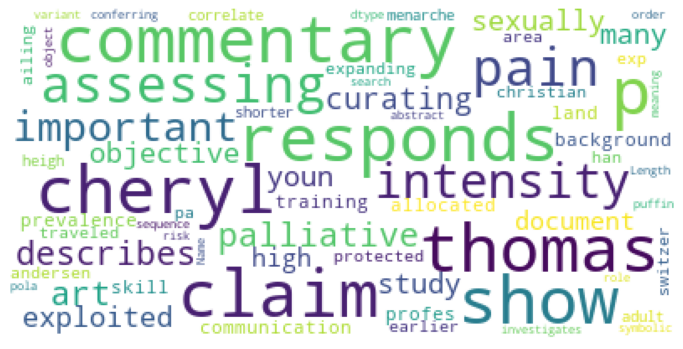

In [29]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df['abstract']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [427]:
common_words = get_top_n_grams(df['abstract'],(1,1), 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in the abstract after removing stop words and lemmatization"))
fig.show()

### most frequent words as 2words

In [31]:

common_words = get_top_n_grams(df['abstract'],(2,2), 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the abstract after removing stop words and lemmatization"))
fig.show()

### most frequent words as 3words

In [32]:


common_words = get_top_n_grams(df['abstract'],(3,3), 20 )
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 trigrams in the abstract"))
fig.show()

###  Vectorize the text data using the TfidfVectorizer.

In [256]:
df_tfidf=TfidfVect(df.abstract)

###  Vectorize the text data using CountVectorizer.

In [46]:
df_cv=CountVect(df.abstract)

# Topic Modeling

### NMF Topic Modeling 

In [704]:
nmf_model = NMF(16,random_state=11)
doc_topic1 = nmf_model.fit_transform(df_tfidf)

/Users/workplace/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/Users/workplace/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [705]:
display_topics(nmf_model, tfidf.get_feature_names(),6)


Topic  0
political, state, power, new, politics, process

Topic  1
health, mental, intervention, policy, public, service

Topic  2
covid, pandemic, lockdown, country, response, impact

Topic  3
woman, party, gender, labour, policy, men

Topic  4
police, crime, knife, policing, armed, officer

Topic  5
student, school, education, university, learning, teaching

Topic  6
patient, cancer, cell, treatment, disease, drug

Topic  7
child, parent, family, childrens, abuse, parental

Topic  8
food, safety, insecurity, income, security, country

Topic  9
age, factor, study, association, associated, level

Topic  10
care, people, service, work, community, disability

Topic  11
financial, sib, program, investment, well, economy

Topic  12
digital, activity, physical, platform, ci, online

Topic  13
migrant, surveillance, border, biopolitical, eu, right

Topic  14
sexual, drug, violence, gender, minority, sexuality

Topic  15
justice, climate, geographical, nepal, change, indigenous


In [48]:
nmf_model2 = NMF(12 ,random_state=11)
doc_topic2 = nmf_model2.fit_transform(df_tfidf)

/Users/workplace/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [49]:
display_topics(nmf_model2, tfidf.get_feature_names(), 6)


Topic  0
political, state, new, power, policy, politics

Topic  1
sexual, drug, violence, gender, minority, health

Topic  2
covid, health, pandemic, mental, lockdown, country

Topic  3
woman, party, gender, labour, policy, men

Topic  4
justice, climate, geographical, nepal, indigenous, change

Topic  5
student, school, education, university, learning, digital

Topic  6
patient, age, study, factor, disease, ci

Topic  7
child, parent, family, childrens, abuse, parental

Topic  8
food, income, country, insecurity, safety, security

Topic  9
police, crime, knife, policing, armed, officer

Topic  10
care, people, service, community, disability, health

Topic  11
migrant, surveillance, border, biopolitical, right, eu


In [261]:
nmf_model3 = NMF(10,random_state=11,solver='mu',shuffle =True)
doc_topic3 = nmf_model3.fit_transform(df_tfidf)

In [264]:
display_topics(nmf_model3, tfidf.get_feature_names(),20)


Topic  0
policy, political, community, practice, work, approach, new, process, people, state, study, local, context, development, care, economic, power, within, way, based

Topic  1
health, mental, intervention, psychological, study, covid, lockdown, distress, people, impact, service, outcome, care, sexual, participant, depression, symptom, family, physical, stress

Topic  2
covid, pandemic, financial, country, crisis, medium, response, news, lockdown, coronavirus, state, economy, inclusion, well, impact, china, global, public, system, political

Topic  3
woman, sexual, gender, party, violence, men, feminist, labour, experience, drug, likely, sexuality, strategy, gendered, partner, policy, voter, refugee, sex, older

Topic  4
police, justice, crime, knife, policing, climate, violence, criminal, law, armed, officer, medium, victim, nepal, community, routinely, procedural, offending, evidence, geographical

Topic  5
student, education, school, university, learning, online, disability, t

In [265]:
nmf_model4 = NMF(9,random_state=11)
doc_topic4 = nmf_model4.fit_transform(df_tfidf)

In [266]:
display_topics(nmf_model4, tfidf.get_feature_names(),20)


Topic  0
political, policy, state, new, economic, power, right, politics, local, process, practice, human, environmental, role, approach, national, climate, development, change, issue

Topic  1
sexual, drug, violence, gender, minority, health, sex, sexuality, identity, lgbtq, consumption, festival, experience, men, harm, people, orientation, practice, queer, older

Topic  2
covid, health, pandemic, mental, lockdown, country, financial, psychological, impact, distress, symptom, medium, stress, response, public, gi, crisis, level, online, population

Topic  3
woman, party, gender, labour, policy, migrant, feminist, men, strategy, voter, politics, birth, new, female, condom, gendered, refugee, experience, life, likely

Topic  4
police, crime, justice, knife, policing, criminal, violence, armed, officer, law, sib, medium, routinely, offending, safety, jurisdiction, victim, program, procedural, csam

Topic  5
student, school, education, university, learning, digital, online, teaching, divi

## Save Best Result 

In [267]:
pickle.dump(doc_topic4, open('doc_topic4.pkl', 'wb'))


In [33]:
file = open("doc_topic2.pkl",'rb')
doc_topic2= pickle.load(file)
file.close()

### LDA Topic Modeling 

#### LDA Topic Modeling  CountVectorizer

In [281]:
lda = LatentDirichletAllocation(n_components=10)
lda.fit(df_cv)
display_topics(lda, cv.get_feature_names(),20)


Topic  0
study, safety, child, outcome, age, result, year, approach, ci, based, factor, day, childhood, people, finding, development, model, mar, using, associated

Topic  1
age, study, group, may, activity, disease, crime, year, rate, different, covid, cell, prevalence, digital, change, result, platform, per, physical, risk

Topic  2
country, labour, worker, migrant, patient, stenosis, uk, result, party, mine, medium, study, egjoo, twin, practice, le, pair, age, europe, associated

Topic  3
health, study, covid, level, pandemic, country, method, mental, intervention, care, result, people, impact, well, using, student, factor, public, patient, read

Topic  4
political, state, new, woman, study, politics, approach, policy, national, law, development, police, violence, justice, international, within, conflict, issue, discourse, party

Topic  5
child, study, gender, relationship, family, practice, work, right, justice, human, people, climate, experience, care, participant, well, environm

#### LDA Topic Modeling  TFIDF

In [258]:
lda = LatentDirichletAllocation(n_components=13)
lda.fit(df_tfidf)
display_topics(lda, tfidf.get_feature_names(),10)


Topic  0
cyber, mine, criminal, la, de, fraud, cluster, hypothesis, flint, compassion

Topic  1
feminist, inside, athlete, street, pt, presentation, humanitarian, gambling, football, ui

Topic  2
italian, bone, cybercrime, gdm, lma, municipality, epds, edge, university, cybersecurity

Topic  3
music, surveillance, ice, conceived, eating, advocacy, disabled, misoprostol, gang, hcws

Topic  4
biopolitical, diaspora, illness, indonesia, mass, sep, egjoo, fat, ethic, prep

Topic  5
university, platelet, bibliographical, peg, thesis, rhumgdf, xf, toronto, includes, placebo

Topic  6
justice, nepal, criminal, peacebuilding, slavery, hand, university, judicial, ignition, gbv

Topic  7
aboriginal, commerce, centrality, vaccination, sign, internet, football, ffr, homosexual, nrf

Topic  8
knife, csam, vehicle, stenosis, prisoner, og, ce³, planner, aristotle, craftsmanship

Topic  9
study, health, policy, people, woman, community, practice, covid, child, country

Topic  10
university, behavior,

by reading the topics we got using both models, we can see that NMF performs better than LDA, the words in each topic are clearly related to each other and distuingshable from words in other topics.

In [910]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781 entries, 1 to 1220
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       781 non-null    object 
 1   authers     781 non-null    object 
 2   abstract    781 non-null    object 
 3   type        781 non-null    object 
 4   date_pub    560 non-null    float64
 5   journal     545 non-null    object 
 6   date_added  498 non-null    object 
 7   figuers     781 non-null    int64  
 8   full_text   781 non-null    object 
 9   citation    781 non-null    int64  
 10  interest    724 non-null    float64
 11  reads       781 non-null    int64  
 12  detect      781 non-null    object 
 13  topic_dist  781 non-null    object 
 14  main_topic  781 non-null    int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 113.8+ KB


In [421]:
def display_wordcloud(df, title, n_components):
    plt.figure()
    j = np.ceil(n_components/4)
    for i in range(n_components):
        plt.subplot(j, 4, i+1).set_title("Topic #" + str(i))
        plt.plot()
        plt.imshow(WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=9,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df.iloc[i])))
        i=i+1
        plt.axis("off")
        
    fig.suptitle(title)
    plt.show()

In [ ]:
display_wordcloud(df_cx,'Topics Word Cloud', 12)



# CorEx Topic Modeling

In [35]:
vectorizer2 = CountVectorizer(max_features=20000,binary=True) 
doc_word = vectorizer2.fit_transform(df.abstract)
words = list(np.asarray(vectorizer2.get_feature_names()))


In [36]:
topic_model = ct.Corex(n_hidden=12, words=words, seed=1)
doc_topic5 = topic_model.fit_transform(doc_word,anchors=[['political','politics','state','surveillance','biopolitical','migrant','indigenous']
                                  , ['covid','pandemic','coronavirus','lockdown']
                                  ,['student','academic','school', 'education', 'university', 'learning']
                                 ,['care', 'people', 'service', 'community','training']
                                 ,['mental','psychological','depression','stress','burnout','emotion']                       
                                 ,['crime','police','rape','exploited','knife','armed', 'officer', 'violence']
                                 ,['child','sexually', 'abuse', 'family', 'childrens' ]
                                 ,['sexual','sex', 'sexuality']
                                 ,['financial','security', 'income', 'country','poverty','economy','investment']
                                 ,['climate','environment','sustainability']
                                 ,['woman', 'gender','feminist']
                                 ,['patient','medicine','chronic','health','pain', 'age','disease','cancer','physical','treat','drug']],anchor_strength=7, words=words, docs=df.abstract)

In [37]:
topic_model.p_y_given_x[1]

array([1.00000000e-06, 1.00000000e-06, 1.55170516e-05, 9.99999000e-01,
       9.99999000e-01, 4.05705183e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 9.99999000e-01])

In [373]:
topics = topic_model.get_topics()
df_cx=pd.DataFrame()

for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))
    temp=pd.DataFrame({topic_words})
    df_cx=df_cx.append(temp)

0: political,state,politics,migrant,surveillance,power,regime,biopolitical,right,united
1: covid,pandemic,lockdown,coronavirus,online,virus,syndrome,protective,cov,sars
2: education,student,university,school,learning,academic,educational,teaching,undergraduate,formal
3: people,community,service,care,training,support,young,professional,access,qualitative
4: mental,psychological,stress,depression,emotion,burnout,distress,sd,recruited,anxiety
5: violence,crime,police,officer,armed,rape,knife,criminal,policing,exploited
6: child,family,abuse,childrens,parent,sexually,childhood,birth,friend,parental
7: sexual,sex,sexuality,queer,survivor,marriage,lgbtq,festival,removal,al
8: country,income,security,economy,financial,poverty,investment,market,economic,decade
9: environment,climate,sustainability,environmental,ecological,critique,city,field,issue,sustainable
10: woman,gender,feminist,men,gendered,bisexual,identify,percent,experience,transgender
11: health,patient,disease,age,drug,cancer,chron

In [374]:
df_cx.reset_index(inplace=True)

df_cx.drop('index',axis=1,inplace=True)

In [382]:
df_cx

,0,1,2,3,4,5,6,7,8,9
0,political,state,politics,migrant,surveillance,power,regime,biopolitical,right,united
1,covid,pandemic,lockdown,coronavirus,online,virus,syndrome,protective,cov,sars
2,education,student,university,school,learning,academic,educational,teaching,undergraduate,formal
3,people,community,service,care,training,support,young,professional,access,qualitative
4,mental,psychological,stress,depression,emotion,burnout,distress,sd,recruited,anxiety
5,violence,crime,police,officer,armed,rape,knife,criminal,policing,exploited
6,child,family,abuse,childrens,parent,sexually,childhood,birth,friend,parental
7,sexual,sex,sexuality,queer,survivor,marriage,lgbtq,festival,removal,al
8,country,income,security,economy,financial,poverty,investment,market,economic,decade
9,environment,climate,sustainability,environmental,ecological,critique,city,field,issue,sustainable


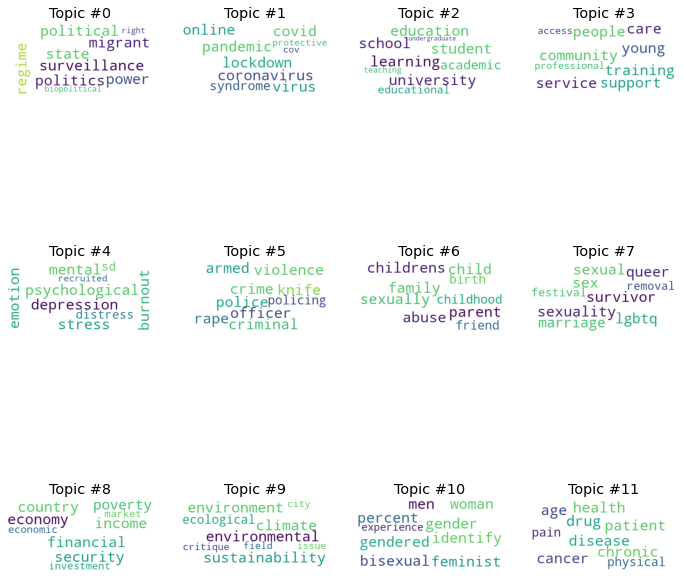

In [420]:
display_wordcloud(df_cx,'Topics Word Cloud', 12)


# Assign  topics to rows

In [42]:
df.shape

(1185, 13)

In [51]:
df['topic_dist'] = [i for i in doc_topic2]
df['main_topic'] = df.apply(lambda row: row['topic_dist'].tolist().index(max(row['topic_dist'])), axis=1)

In [268]:
df['topic_dist2'] = [i for i in doc_topic4]
df['main_topic2'] = df.apply(lambda row: row['topic_dist2'].tolist().index(max(row['topic_dist2'])), axis=1)

In [62]:
df['topic_dist_cx'] = [i for i in topic_model.p_y_given_x]
df['main_topic_cx'] = df.apply(lambda row: row['topic_dist_cx'].tolist().index(max(row['topic_dist_cx'])), axis=1)

In [269]:
df.head(5)

,title,authers,abstract,type,date_pub,journal,date_added,figuers,full_text,citation,interest,reads,or_abt,topic_dist,main_topic,topic_dist_cx,main_topic_cx,topic_dist2,main_topic2
1,Myths about Myths? A Commentary on Thomas (202...,"['Ellen Daly', 'Olivia Smith', 'Hannah Bows[.....",commentary responds claim cheryl thomas show p...,Article,2021.0,Journal of Gender-Based Violence,6d ago,1,\nDownload,0,1.0,32,This commentary responds to claims that resear...,"[0.01677185821655876, 0.010384473306029299, 1....",politics,"[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 0.999999, ...",criminology,"[0.018421718658978733, 0.011069431738077928, 0...",0
4,A direct observation of pain scale use in five...,"['Laura Jenkins', 'Ruth H Parry', 'Christina F...",assessing pain intensity important palliative ...,Article,2021.0,Patient Education and Counseling,Oct 28,0,\nRequest full-text,0,0.0,9,Objective Assessing pain intensity is an impor...,"[0.0, 0.0, 0.0, 0.0, 0.020710575971157386, 0.0...",community_service,"[1e-06, 1e-06, 1.5517051613327514e-05, 0.99999...",community_service,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0767757957118...",8
5,The Cold Truth: Art as Fulcrum for Recovery in...,['Eloise Malone'],describes art curating sexually exploited youn...,Article,2017.0,Journal of Social Work Practice,Oct 25,0,\nDownload,1,0.0,22,This article describes art curating with sexua...,"[0.010833006934524003, 0.0, 0.0, 0.0, 0.002248...",community_service,"[1e-06, 1e-06, 1e-06, 0.999999, 1e-06, 0.99999...",community_service,"[0.00831823344595343, 0.0, 0.0, 0.0, 0.0027316...",8
7,Dispositional Mindfulness Reduces Burnout and ...,"['Denisse Zúñiga', 'Manuel Torres-Sahli', 'Att...",objective many study document high prevalence ...,Article,2021.0,Mindfulness,Oct 21,1,\nDownload,0,2.0,40,Objectives Many studies document the high prev...,"[0.0, 0.0, 0.051700673281299715, 0.0, 0.0, 0.1...",education,"[0.999999, 0.999999, 0.999999, 0.999999, 0.999...",politics,"[0.0, 0.0, 0.05381117162792575, 0.0, 0.0011979...",5
10,Realtalk Evidence-Based Communication Training...,"['Ruth H Parry', 'Becky Whittaker', 'Marco Pin...",background communication skill training profes...,Preprint,2021.0,NaN,Oct 14,1,\nDownload,0,2.0,43,BACKGROUND Communication skills training for p...,"[0.0, 0.0, 0.0, 0.0, 0.0018867439134512228, 0....",community_service,"[1e-06, 1e-06, 0.999999, 0.999999, 1e-06, 1e-0...",education,"[0.0, 0.0, 0.0, 0.0, 0.022442236610402157, 0.0...",8


In [271]:
df['main_topic'].replace({0:'politics',1:'sexuality',2:'covid',3:'women',4:'politics',5:'education',6:'health_medicine',7:'child_family',8:'economy',9:'criminology',10:'community_service',11:'politics'}, inplace=True)
df['main_topic_cx'].replace({0:'politics',1:'covid',2:'education',3:'community_service',4:'mental_health',5:'criminology',6:'child_family',7:'sexuality',8:'economy',9:'environment',10:'women',11:'health_medicine'}, inplace=True)
df['main_topic2'].replace({0:'politics_and_economics',1:'sexuality',2:'covid',3:'women',4:'criminology',5:'education',6:'health_medicine',7:'child_family',8:'community_service'}, inplace=True)



In [272]:
df.sample(10)

,title,authers,abstract,type,date_pub,journal,date_added,figuers,full_text,citation,interest,reads,or_abt,topic_dist,main_topic,topic_dist_cx,main_topic_cx,topic_dist2,main_topic2
855,A scoping review of Chinese families caring fo...,"['Abner Weng Cheong Poon', 'Alyssa Cassidy']",family may experience negative impact caring r...,Article,1.0,Journal of Ethnic & Cultural Diversity in Soc...,NaN,0,\nRequest full-text,1,0.0,7,Families may experience the negative impact of...,"[0.0, 0.0, 0.022769506599983006, 0.00529821316...",community_service,"[1e-06, 1e-06, 1e-06, 0.999999, 0.999999, 1e-0...",community_service,"[0.0, 0.0, 0.024911090178535083, 0.00711931075...",community_service
1223,COVID-19 Scientific Facts vs. Conspiracy Theor...,"['Marios Constantinou', 'Antonios Kagialis', '...",science may failing convince significant numbe...,Article,1.0,International Journal of Environmental Resear...,Jun 14,1,\nDownload,2,4.9,70,Science may be failing to convince a significa...,"[0.005811074337215026, 0.0011535444888299644, ...",covid,"[0.999999, 0.999999, 0.999999, 0.999999, 0.999...",politics,"[0.0029070544841611813, 0.002081198244175046, ...",covid
1281,Is driver education contributing towards road ...,"['Maryam Akbari', 'Kamran B Lankarani', 'Seyed...",background vast amount effect driver education...,Literature Review,1.0,Journal of Injury & Violence Research,Jan 28,1,\nDownload,1,2.9,93,Background: There is a vast amount of literatu...,"[0.0, 0.0, 0.0, 0.0, 0.0016610785929793389, 0....",health_medicine,"[1e-06, 1e-06, 0.999999, 0.999999, 1e-06, 2.76...",education,"[0.0, 0.0, 0.0, 0.0, 0.013997796505731549, 0.0...",health_medicine
719,Can “the oven bird” Migrate North of the border?,['Annie Bunting'],david engels elegant piece oven bird song insi...,Chapter,NaN,NaN,NaN,0,\nRequest full-text,0,0.0,3,In David Engel’s elegant 1984 piece “The Oven ...,"[0.015212617870269021, 0.0, 0.0, 0.0, 0.063622...",community_service,"[1e-06, 1e-06, 1e-06, 0.999999, 1e-06, 0.99999...",community_service,"[0.027980661853934018, 0.0, 0.0, 0.0, 0.024812...",community_service
1760,Peter Olen: Wilfrid Sellars and the Foundation...,['Catherine Legg'],contribution included present issue originally...,Article,9.0,Journal for the History of Analytical Philosophy,NaN,0,\nDownload,0,0.1,25,All contributions included in the present issu...,"[0.015008293364546866, 0.0, 0.0, 0.0, 0.002209...",health_medicine,"[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-...",politics,"[0.01588625498187335, 0.0, 0.0, 0.0, 0.0, 0.00...",health_medicine
795,Explaining divergent National Responses to Cov...,"['Linda Weiss', 'Elizabeth Thurbon']",develop state capacity framework account diffe...,Article,1.0,New Political Economy,NaN,1,\nDownload,0,2.0,38,We develop a state capacity framework to accou...,"[0.07786153232036157, 0.0, 0.07966525589428984...",covid,"[0.999999, 0.999999, 1e-06, 1e-06, 1e-06, 0.99...",politics,"[0.07911231805061936, 0.0, 0.0810838544694334,...",covid
1657,Primary Crime Prevention Apps: A Typology and ...,"['Mark A. Wood', 'Stuart Ross', 'Diana Johns']",last decade array smartphone apps designed pre...,Article,1.0,Trauma Violence & Abuse,Mar 24,0,\nRequest full-text,2,1.8,66,"In the last decade, an array of smartphone app...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0210051020610...",criminology,"[1e-06, 1e-06, 0.00012216510372806182, 1e-06, ...",criminology,"[0.0, 0.0, 0.0, 0.0, 0.17257450289507104, 0.0,...",criminology
1883,Terror threats and civil liberties: when do ci...,"['Walter L. Brent van der Hell', 'Hjalti Björn...",threat subversive threatening enemy sometimes ...,Article,1.0,Icelandic Review of Politics & Administration,Jun 30,1,\nDownload,0,1.3,40,Threats from subversive or threatening enemies...,"[0.029929917713374294, 5.014258775951719e-05, ...",politics,"[0.999999, 1e-06, 1e-06, 1e-06, 1e-06, 4.60581...",politics,"[0.03204710739783168, 0.0008939188618378922, 0...",politics_and_economics
521,The effectiveness and suitability of intervent...,['Brenda A

## Improving Topics

To better understand the mistakes our NMF model makes, we're analysing the topics in bigrams to see if the terms acctually belong to the topic or not 

In [273]:
df3 = pd.DataFrame()
topics=['politics_and_economics','sexuality','covid','women','criminology','education','health_medicine','child_family','community_service']
for t in topics:
    common_words_topic = get_top_n_grams(df[df['main_topic2']==t]['abstract'],(2,2), 7)
    dft = pd.DataFrame(common_words_topic)
    dft["topic"]=t
    df3=df3.append(dft)


In [274]:
df3.shape

(63, 3)

In [275]:
df3.sample(4)

,0,1,topic
3,migrant woman,8,women
1,mental health,12,child_family
5,child young,8,child_family
1,digital platform,27,health_medicine


In [276]:
fig = px.bar(df3, x=1, y='topic', template='plotly_white', orientation='h',
             labels={1: 'freqcy', 0: 'Bigram', 'topic': 'topic'},
             color=0, color_discrete_sequence=px.colors.qualitative.Plotly_r)
fig.update_layout(font=dict(size=10, color='DarkSlateGray'))
fig.update_layout(width=1200, height=500)
fig.show()

fig.write_html("figures/NMF_topics_bigram.html")


In [70]:
df4 = pd.DataFrame()
topics2=['politics','community_service','covid','environment','women','sexuality','criminology','education','health_medicine','mental_health','child_family','economy']
for t in topics2:
    common_words_topic = get_top_n_grams(df[df['main_topic_cx']==t]['abstract'],(2,3), 7)
    dft = pd.DataFrame(common_words_topic)
    dft["topic"]=t
    df4=df4.append(dft)



In [84]:
fig = px.bar(df4, x=1, y='topic', template='plotly_white', orientation='h',
             labels={1: 'freqcy', 0: 'Bigram', 'topic': 'topic'},
             color=0, color_discrete_sequence=px.colors.qualitative.Plotly_r)
fig.update_layout(font=dict(size=10, color='DarkSlateGray'))
fig.update_layout(width=1200, height=500)
fig.show()

fig.write_html("figures/corex_topics_bigram.html")


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1185 entries, 1 to 1898
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          1185 non-null   object 
 1   authers        1185 non-null   object 
 2   abstract       1185 non-null   object 
 3   type           1185 non-null   object 
 4   date_pub       808 non-null    float64
 5   journal        793 non-null    object 
 6   date_added     677 non-null    object 
 7   figuers        1185 non-null   int64  
 8   full_text      1185 non-null   object 
 9   citation       1185 non-null   int64  
 10  interest       1099 non-null   float64
 11  reads          1185 non-null   int64  
 12  or_abt         1185 non-null   object 
 13  topic_dist     1185 non-null   object 
 14  main_topic     1185 non-null   object 
 15  topic_dist_cx  1185 non-null   object 
 16  main_topic_cx  1185 non-null   object 
dtypes: float64(2), int64(3), object(12)
memory usage: 19

In [277]:
df.to_csv('data_topics.csv', index=False)

# Discovering sub-topics

In [182]:
import warnings
warnings.filterwarnings("ignore")


In [282]:
sub_topics_dict={}
def find_sub_topics(main_df,topic_list,topic_num_range):

    for t in topic_list:
        df=main_df[main_df['main_topic2']==t]
        tfidf_sub = TfidfVectorizer()
        X_tfidf_sub = tfidf_sub.fit_transform(df.abstract).toarray()
        tfidf=pd.DataFrame(X_tfidf_sub,index=df,columns=tfidf_sub.get_feature_names())
        for i in topic_num_range:
            sub_topics_dict[f'{t}_tfidf{i}']=tfidf
            sub_topics_dict[f'{t}_nmf_model{i}']=NMF(i,random_state=11)
            sub_topics_dict[f'{t}_doc_topic{i}']=sub_topics_dict[f'{t}_nmf_model{i}'].fit_transform(tfidf)
            sub_topics_dict[f'{t}_tfidf_vec{i}']=tfidf_sub

In [283]:
find_sub_topics(df,topics,list(range(2,8)))

In [284]:
nmf_model_crime

NMF(n_components=5, random_state=11)

In [289]:
display_topics(sub_topics_dict['politics_and_economics_nmf_model7'], sub_topics_dict['politics_and_economics_tfidf_vec7'].get_feature_names(),7)


Topic  0
energy, urban, climate, change, economic, city, policy

Topic  1
surveillance, border, migrant, biopolitical, eu, right, human

Topic  2
solidarity, campaign, union, worker, labour, labor, transnational

Topic  3
power, relation, ecological, phenomenon, environmental, political, human

Topic  4
political, narrative, religion, national, religious, indonesia, public

Topic  5
de, la, le, et, en, mine, que

Topic  6
state, governance, csr, royalty, country, eiti, resource


In [290]:
display_topics(sub_topics_dict['education_nmf_model3'], sub_topics_dict['education_tfidf_vec3'].get_feature_names(),7)


Topic  0
student, digital, online, divide, university, communication, learning

Topic  1
bibliographical, includes, reference, thesis, toronto, university, fall

Topic  2
school, education, sex, girl, disability, transition, life


In [291]:
display_topics(sub_topics_dict['women_nmf_model4'], sub_topics_dict['women_tfidf_vec4'].get_feature_names(),10)


Topic  0
woman, gender, condom, health, female, study, men, older, method, life

Topic  1
party, electoral, appeal, opposition, voter, woman, policy, state, manifesto, building

Topic  2
migrant, labour, market, policy, country, new, employment, immigration, irregular, woman

Topic  3
feminist, academic, activism, activist, visualisation, academy, change, experience, within, workarounds


In [292]:
display_topics(sub_topics_dict['sexuality_nmf_model4'], sub_topics_dict['sexuality_tfidf_vec4'].get_feature_names(),10)


Topic  0
sexual, health, people, adult, young, minority, study, lockdown, older, identity

Topic  1
coumarins, coumarin, compound, various, widely, performed, perfume, crystalline, explicates, scent

Topic  2
drug, lgbtq, gender, consumption, practice, sex, particular, effect, consumer, policy

Topic  3
violence, festival, sexual, music, argue, feminist, harm, framework, experience, victim


In [293]:
display_topics(sub_topics_dict['covid_nmf_model4'], sub_topics_dict['covid_tfidf_vec4'].get_feature_names(),10)


Topic  0
mental, health, covid, psychological, distress, gi, symptom, impact, disorder, participant

Topic  1
financial, well, inclusion, study, economy, country, understand, effect, system, pandemic

Topic  2
behavior, lockdown, change, time, diary, risk, activity, location, uk, population

Topic  3
health, policy, covid, response, pandemic, medium, crisis, state, news, public


In [298]:
display_topics(sub_topics_dict['criminology_nmf_model2'], sub_topics_dict['criminology_tfidf_vec2'].get_feature_names(),10)


Topic  0
justice, police, crime, climate, knife, policing, law, criminal, medium, violence

Topic  1
sib, program, investment, valuation, financial, method, united, return, market, crisis


In [302]:
display_topics(sub_topics_dict['health_medicine_nmf_model5'], sub_topics_dict['health_medicine_tfidf_vec5'].get_feature_names(),10)


Topic  0
study, relationship, factor, measure, model, participant, result, using, safety, level

Topic  1
activity, physical, digital, platform, ci, guideline, adherence, user, eg, adolescent

Topic  2
ui, age, prevalence, rate, per, global, burden, standardised, migraine, point

Topic  3
patient, peg, rhumgdf, platelet, day, treatment, group, drug, placebo, cell

Topic  4
driving, phone, mobile, cell, vehicle, driver, behaviour, planner, text, road


In [306]:
display_topics(sub_topics_dict['child_family_nmf_model7'], sub_topics_dict['child_family_tfidf_vec7'].get_feature_names(),10)


Topic  0
child, parent, family, school, mar, parental, health, conceived, outcome, substance

Topic  1
food, insecurity, system, country, security, hunger, african, nutritional, safety, brief

Topic  2
childhood, everyday, researching, book, empirical, life, documentation, digital, post, youth

Topic  3
food, solidarity, information, income, access, low, participant, practice, french, clarified

Topic  4
poverty, household, energy, heat, water, fuel, policy, relation, evidence, income

Topic  5
abuse, internet, material, victim, online, csam, pre, technology, child, sexual

Topic  6
design, childrens, child, centred, mobility, disaster, ipm, framework, wheelchair, dream


In [309]:
display_topics(sub_topics_dict['community_service_nmf_model5'], sub_topics_dict['community_service_tfidf_vec5'].get_feature_names(),10)


Topic  0
care, work, family, service, caring, residential, practice, patient, palliative, support

Topic  1
people, community, disability, aboriginal, health, service, project, indigenous, right, approach

Topic  2
birth, home, evidence, resource, transfer, maker, low, policy, hospital, stakeholder

Topic  3
american, community, legal, perception, engels, greenhouse, resident, town, study, oven

Topic  4
reintegration, survivor, trafficking, program, regime, human, procedural, assistance, nigeria, distinction


# saving the sub-topics dictionary 

In [310]:
pickle.dump(sub_topics_dict, open('sub_topics_dict.pkl', 'wb'))

# Conclusion 

we found that NMF gives the best results when the number of topics is 9, CorEx gives perfect results when we use the top words we got in NMF as anchor words, but since it doesn't give a propability it's not useful in determining the dominant topic in each document. the topics we found present in social science articles are as follows:

- Politics And Economics
- Sexuality
- Covid
- women
- Criminology
- Education 
- Health and medicine
- Family and child
- Community Service 

we tried to get the subtopics using NMF, and we found that some topics have well-saparated subtopics, but for other topics the results are kind of messy. we will try to improve sub-topics in fututer work by expermenting with corex and anchor words.